<a href="https://colab.research.google.com/github/Leonel-Ariel-Ruppel/READ-ME/blob/main/Maestr%C3%ADa_teor%C3%ADa_12_Redes_Neuronales_Recurrentes_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/maestria/teoria/12 - Redes Neuronales Recurrentes - LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Recurrentes (RNN)


Las redes neuronales recurrentes o RNN (Recurrent Neural Networks) son algoritmos que sirven para datos secuenciales muy utilizados en Natural Language Processing (NLP).

Se trata de algoritmos que tienen la capacidad de recordar sus entradas, debido a la memoria interna que poseen, lo que hace que se conviertan en una excelente opción en la solución de problemas de aprendizaje automático que involucren datos secuenciales.

La arquitectura de las redes neuronales recurrentes facilita que el programa o aplicación desarrollado con ellas pueda recordar y olvidar la información que procesa. De esta manera, este tipo de modelo de machine learning es capaz de recordar datos procesados al principio de la secuenciación para asociarlos con datos nuevos que va analizando.

Esto hace que las redes neuronales recurrentes también sean especialmente útiles para la creación de texto. Y es que, son capaces de analizar fragmentos de texto y generar nuevos contenidos a partir de ello. Así, una de sus aplicaciones la está encontrando en el desarrollo de aplicaciones de texto predictivo.

Para ver una explicación completa de las redes neuronales LSTM haga click [aqui](https://youtu.be/1BubAvTVBYs)

##Predicción de cotizaciones de AAPL

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM


### Levantamos el archivo y dividimos en train y test usando train los datos del 2016 y para test 2017

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/codificandobits/Prediccion_de_acciones_en_la_bolsa_con_redes_LSTM/master/AAPL_2006-01-01_to_2018-01-01.csv") #[:100]
#data = pd.read_csv("{}/AAPL_2006-01-01_to_2018-01-01.csv".format(contentFolder), index_col='Date', parse_dates=['Date'])
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
len(data)

3019

In [ ]:
#train-test split
train = data[:2016].iloc[:,4:5] #traigo todas las filas hasta el año 2016 y la 5ta columna que es Close.
test = data[2016:].iloc[:,4:5]

In [ ]:
len(train)

2016

In [ ]:
len(test)

1003

### Graficamos el valor de la accion en el tiempo

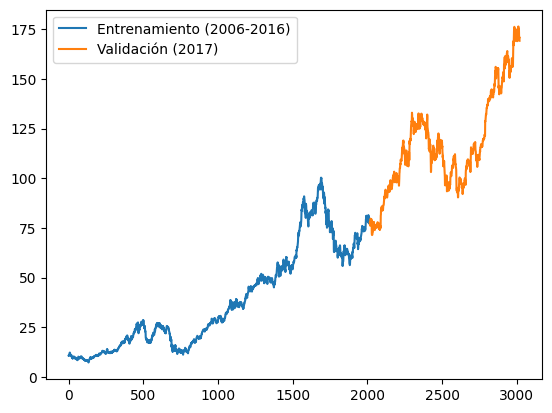

In [ ]:
train['Close'].plot(legend=True)
test['Close'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()


### Normalizacion de los datos
Si observamos los datos de la accion podemos ver que la misma posee un comportamiento creciente

In [ ]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1)) #el output de este scaler va a estar entre 0 y 1 (X-Xmin)/(Xmax-Xmin)
train_scaled = sc.fit_transform(train) #aplico el scaler a los datos de entrenamiento.

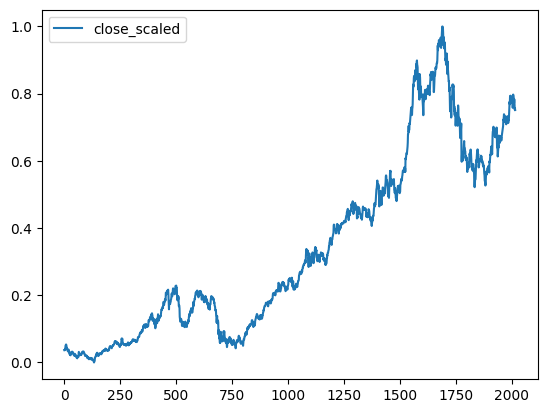

In [ ]:
#datos luego de aplicar scaler:
aux = train
aux["close_scaled"] = train_scaled
aux["close_scaled"].plot(legend=True)
plt.show()
del aux

#Armamos los datos para entrenar.
Armamos los datasets X_train e y_train.
Para entrenar la Red LSTM en nuestro caso tomaremos bloques de 60 datos consecutivos y la idea es que se pueda predecir el siguiente valor.

Los bloques de 60 datos se almacenan en X_train y el dato a predecir se almacenara en y_train



In [ ]:
m = len(train_scaled)
m

2016

What are timesteps? Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.

In [ ]:
time_step = 60 #X de a bloques de 60 cotizaciones y el valor de y es la cotizacion 61. aprox estamos usando los previos 3 meses para predecir el valor.
indexes = []
X_train = []
y_train = [] #Each element of y_train is the value that follows the sequence in X_train
m = len(train_scaled)
ventana = 0
for i in range(time_step,m - ventana): #el loop es entre el valor de time_step, es decir 60 y el valor de (m - ventana), 2016
  X_train.append(train_scaled[i-time_step:i,0]) #me va agregando los 60 valores en un bloque
  y_train.append(train_scaled[i+ventana,0]) #me va agregando los valores del numero 61 en una lista.
  indexes.append(train.index[i+ventana])
X_train, Y_train = np.array(X_train), np.array(y_train) #convertidos en vectores

In [ ]:
print(X_train.shape)

(1956, 60)


In [ ]:
# Reshape X_train para que se ajuste al modelo en Keras
#1956 x 60 x 1 "samples x time steps x features" porq lo pide Keras  features es 1 porq estamos usando solo la columna de close.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
print(X_train.shape) #son 1956 bloques de 60 precios.

(1956, 60, 1)


In [ ]:
X_train

array([[[0.0369654 ],
        [0.03728777],
        [0.03642811],
        ...,
        [0.01353965],
        [0.01235762],
        [0.01783795]],

       [[0.03728777],
        [0.03642811],
        [0.03932946],
        ...,
        [0.01235762],
        [0.01783795],
        [0.0184827 ]],

       [[0.03642811],
        [0.03932946],
        [0.03889963],
        ...,
        [0.01783795],
        [0.0184827 ],
        [0.0184827 ]],

       ...,

       [[0.66054159],
        [0.66913819],
        [0.67386632],
        ...,
        [0.77347948],
        [0.78347303],
        [0.77133032]],

       [[0.66913819],
        [0.67386632],
        [0.67870191],
        ...,
        [0.78347303],
        [0.77133032],
        [0.75263271]],

       [[0.67386632],
        [0.67870191],
        [0.68364496],
        ...,
        [0.77133032],
        [0.75263271],
        [0.75714593]]])

### Creamos el modelo y lo entrenamos
El modelo constara de:
* Capa de entrada con 60 neuronas (ventana de tiempo que usamos para entrenar)
* Una capa LSTM de 50 neuronas
* Una capa de Salida de 1 neurona

In [ ]:
dim_entrada = (X_train.shape[1],1)  #60 x 1
dim_salida = 1
na = 50 #cantidad de neuronas en la capa oculta de LSTM.  Se puede ir probando con diferentes valores para mejorar el performance del modelo.

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse') #root mean square propagation es una variante de stochastic gradient descent que actualiza los weights.
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
62/62 [==============================] - 3s 22ms/step - loss: 0.0135
Epoch 2/20
62/62 [==============================] - 2s 28ms/step - loss: 0.0014
Epoch 3/20
62/62 [==============================] - 2s 35ms/step - loss: 9.9616e-04
Epoch 4/20
62/62 [==============================] - 1s 22ms/step - loss: 8.2166e-04
Epoch 5/20
62/62 [==============================] - 1s 23ms/step - loss: 6.7226e-04
Epoch 6/20
62/62 [==============================] - 1s 22ms/step - loss: 5.9460e-04
Epoch 7/20
62/62 [==============================] - 1s 22ms/step - loss: 5.7735e-04
Epoch 8/20
62/62 [==============================] - 1s 23ms/step - loss: 5.1630e-04
Epoch 9/20
62/62 [==============================] - 1s 22ms/step - loss: 4.6827e-04
Epoch 10/20
62/62 [==============================] - 2s 25ms/step - loss: 4.7682e-04
Epoch 11/20
62/62 [==============================] - 2s 36ms/step - loss: 3.9366e-04
Epoch 12/20
62/62 [==============================] - 2s 25ms/step - loss: 4.3446e-

# Predecimos y graficamos

In [ ]:
X_test = []
y_test = []
indexes = []
test_scaled = sc.transform(test)
m = len(test)
ventana = 0
X_test = []
for i in range(time_step,m-ventana):

  X_test.append(test_scaled[i-time_step:i,0])
  y_test.append(test_scaled[i+ventana,0])
  indexes.append(test.index[i+ventana])
X_test, Y_test = np.array(X_test), np.array(y_test)

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
Y_test = sc.inverse_transform(Y_test.reshape(-1,1)) #aplicar inverse a los datos escalados para volver al formato de precio.


30/30 [==============================] - 1s 10ms/step


In [ ]:
def graficar_predicciones(real, prediccion, indices):
    plt.plot(pd.DataFrame(real, index= indices),color='red', label='Valor real de la acción')
    plt.plot(pd.DataFrame(prediccion, index = indices), color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.xticks(rotation=45)
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

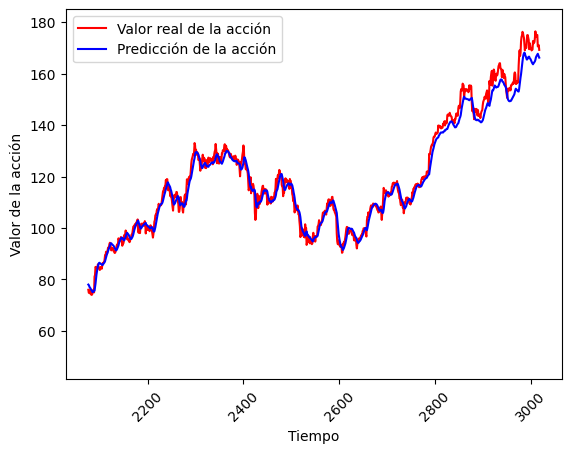

In [ ]:
graficar_predicciones(Y_test, prediccion, indexes)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, prediccion)


11.234138491238381

## Predicción de cotizaciones de Mastercard

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

#set_seed(455)
#np.random.seed(455)

In [ ]:
#dataset de las cotizaciones de mastercard entre 2016 y abril 2024
dataset = pd.read_csv("https://raw.githubusercontent.com/Lashanghainesa/dataset/main/MA.csv", index_col="Date",parse_dates=["Date"]) #transformo la columna date en indice. parse_dates me sirve para despues graficar el eje X.

In [ ]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,95.370003,95.589996,93.720001,94.809998,90.044182,6378700
2016-01-05,95.379997,95.830002,94.410004,94.989998,90.215126,4352500
2016-01-06,93.489998,94.389999,92.980003,93.349998,88.835258,4370000
2016-01-07,91.559998,92.370003,90.680000,91.639999,87.207970,6600000
2016-01-08,91.970001,92.239998,89.720001,89.889999,85.542587,5912100


In [ ]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2.084000e+03
mean,264.945696,267.618872,262.229428,265.010240,260.089491,3.649914e+06
std,108.936277,110.032142,107.826626,108.954040,109.459012,1.723952e+06
min,78.870003,81.739998,78.519997,80.650002,76.749474,6.411000e+05
25%,167.359997,168.902496,165.857498,167.190002,161.513596,2.552525e+06
50%,288.750000,291.925003,284.885010,288.875000,282.976791,3.203450e+06
75%,355.955001,359.622498,351.652496,355.787506,351.570069,4.210250e+06
max,488.529999,490.000000,483.640015,488.640015,487.964142,1.641050e+07


In [ ]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
len(dataset["Close"])

2084

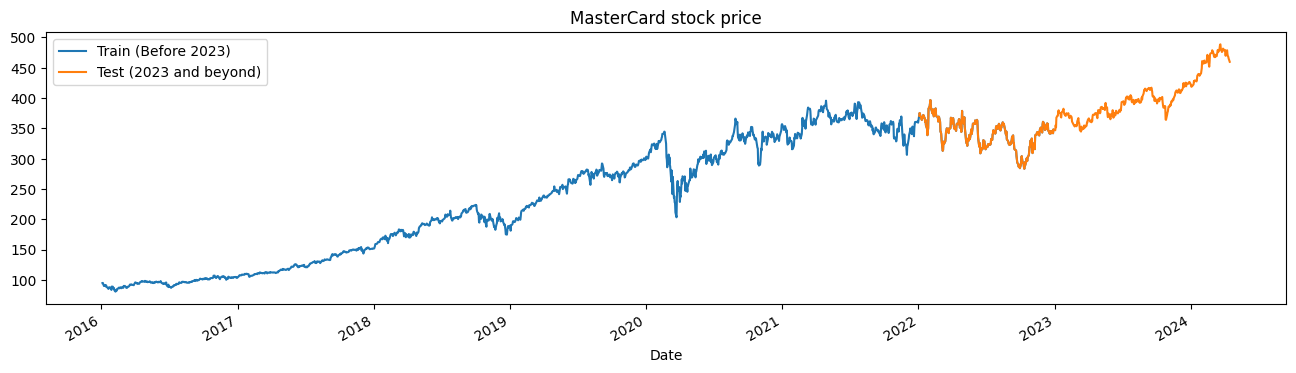

In [ ]:
tstart = 2016 #especifico el año para hacer el split.  datos entre 2016 y 2022 son de entrenamiento, el resto, de test.
tend = 2022

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [ ]:
#hacemos el train/test split utilizando la columna close entre 2016/2022 y despues de 2023
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Close"].values
    test = dataset.loc[f"{tend}":, "Close"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [ ]:
#We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies.
#You can also try using StandardScaler or any other scalar function to normalize your data and improve model performance.
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1) #reacomodar el train set para que haya una columna.
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

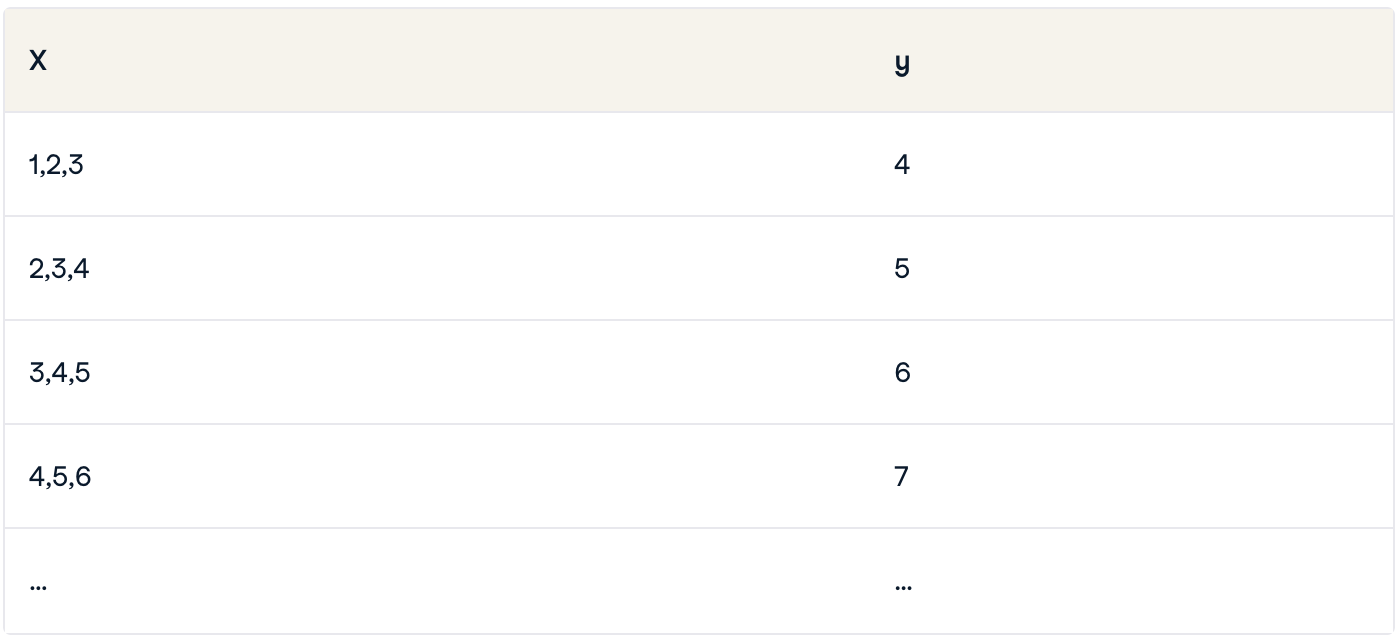

In [ ]:
def split_sequence(sequence, n_steps):  #uso esta función para definir X_train e y_train.
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60 #In this project, we are using 60 n_steps. We can also reduce or increase the number of steps to optimize model performance.
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [ ]:
# Reshaping X_train for model
#We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model.
#The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [ ]:
X_train.shape[1]

60

In [ ]:
X_train.shape

(1702, 60, 1)

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features))) #el modelo tiene una sola capa oculta de LSTM y una capa de salida.  units son las neuronas. tanh es default para función de activación.
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
54/54 [==============================] - 6s 79ms/step - loss: 0.0133
Epoch 2/50
54/54 [==============================] - 3s 57ms/step - loss: 0.0028
Epoch 3/50
54/54 [==============================] - 3s 57ms/step - loss: 0.0022
Epoch 4/50
54/54 [==============================] - 4s 69ms/step - loss: 0.0017
Epoch 5/50
54/54 [==============================] - 4s 78ms/step - loss: 0.0016
Epoch 6/50
54/54 [==============================] - 3s 56ms/step - loss: 0.0014
Epoch 7/50
54/54 [==============================] - 3s 57ms/step - loss: 0.0014
Epoch 8/50
54/54 [==============================] - 4s 71ms/step - loss: 0.0011
Epoch 9/50
54/54 [==============================] - 4s 75ms/step - loss: 0.0011
Epoch 10/50
54/54 [==============================] - 3s 57ms/step - loss: 9.7417e-04
Epoch 11/50
54/54 [==============================] - 3s 57ms/step - loss: 0.0010
Epoch 12/50
54/54 [==============================] - 4s 74ms/step - loss: 9.8798e-04
Epoch 13/50
54/54 [==========

Ahora normalizamos el dataset de test y aplicamos el modelo al test.

In [ ]:
#First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.
dataset_total = dataset.loc[:,"Close"] #me traigo todos los datos de close.
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values  #Encuentro el punto de partida del primer bloque de 60 valores para entrenar el test set, y a partir de ese punto me armo un vector de test. The statement len(all_data) - len(test_data) - 60 identifies this index for us.
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

18/18 [==============================] - 1s 30ms/step


In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

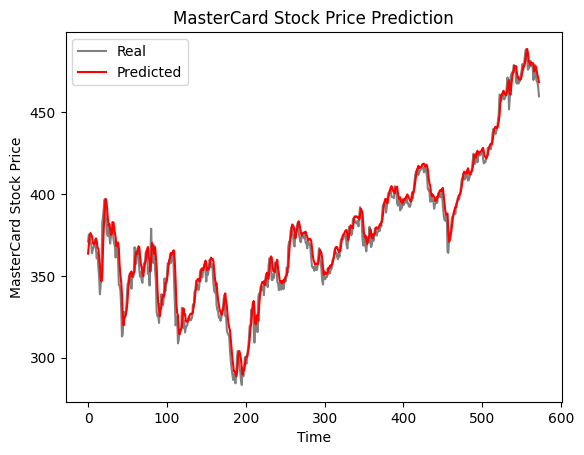

In [ ]:
plot_predictions(test_set,predicted_stock_price)

In [ ]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.89.


##Anexo: gráfico de tanhn (hyperbolic tangent)

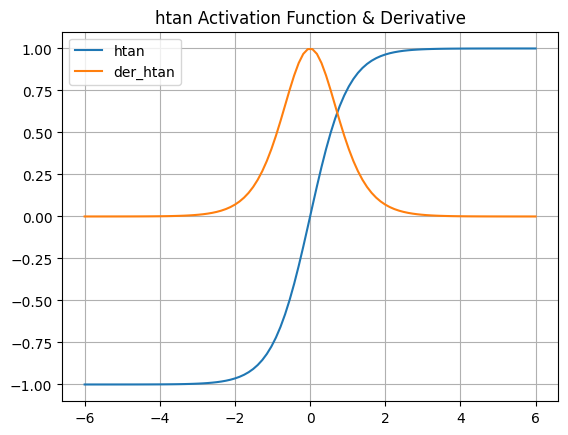

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperbolic Tangent (htan) Activation Function
def htan(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

# htan derivative
def der_htan(x):
  return 1 - htan(x) * htan(x)

# Generating data for Graph
x_data = np.linspace(-6,6,100)
y_data = htan(x_data)
dy_data = der_htan(x_data)

# Graph
plt.plot(x_data, y_data, x_data, dy_data)
plt.title('htan Activation Function & Derivative')
plt.legend(['htan','der_htan'])
plt.grid()
plt.show()